# **ECM502 - Inteligência Artificial**

# Detecção de idade de pessoas em imagens e coloração de imagens preto e branco

## Introdução

Esse projeto utiliza Python e bibliotecas de visão computacional para a detecção de idade em uma imagem e para colorir imagens em escala de cinza. O aplicativo é baseado em uma interface gráfica (GUI) para facilitar o uso.

## Redes Neurais Profundas (DNN)

Redes Neurais Profundas (RNP), também conhecidas como Deep Learning, são um tipo de algoritmo de aprendizado de máquina inspirado no funcionamento do cérebro humano. Elas consistem em uma arquitetura de rede neural composta por múltiplas camadas, permitindo a extração de características complexas a partir dos dados.

Cada camada da rede neural processa e transforma as informações recebidas, passando-as para a próxima camada. As redes neurais profundas são capazes de aprender representações abstratas e hierárquicas dos dados, o que as torna especialmente eficazes em tarefas complexas, como reconhecimento de imagens, processamento de linguagem natural, reconhecimento de voz, entre outros.

O treinamento das redes neurais profundas envolve a alimentação do algoritmo com um grande volume de dados, ajustando os pesos e os parâmetros da rede para minimizar a diferença entre as previsões e os resultados desejados. Isso é feito por meio de algoritmos de otimização, como descida de gradiente.

As redes neurais profundas são compostas por diferentes arquiteturas, como Redes Neurais Convolucionais (CNNs) para processamento de imagens, Redes Neurais Recorrentes (RNNs) para lidar com sequências temporais e outras variações que se adaptam a diferentes tipos de dados e problemas.

Essas redes revolucionaram muitas aplicações de inteligência artificial, obtendo avanços significativos em áreas como diagnóstico médico, carros autônomos, reconhecimento de voz, tradução automática, entre outros, devido à sua capacidade de lidar com dados complexos e extrair padrões de forma eficiente.

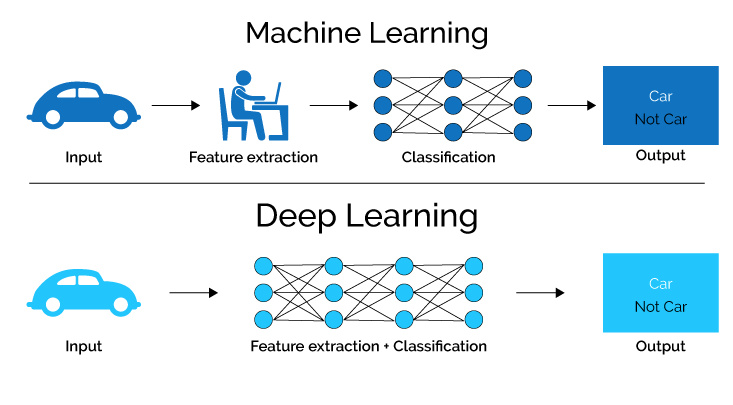

## Caffe Models

O Caffe (Convolutional Architecture for Fast Feature Embedding) é um framework de aprendizado profundo que suporta uma variedade de arquiteturas de aprendizado profundo, como CNN, RCNN, LSTM e redes totalmente conectadas. Com suporte para unidade de processamento gráfico (GPU) e modelos prontos que simplificam a configuração e o treinamento de modelos, o Caffe é mais popular para tarefas de classificação e segmentação de imagens.

No Caffe, é possível definir o modelo, o otimizador e os detalhes de treinamento em arquivos de configuração, graças à sua arquitetura expressiva. Além disso, você pode alternar entre a computação com GPU e a unidade central de processamento (CPU) alterando uma única flag no arquivo de configuração. Juntas, essas características eliminam a necessidade de codificação rígida em seu projeto, o que normalmente é exigido em outras estruturas de aprendizado profundo. O Caffe também é considerado uma das implementações mais rápidas de redes convolucionais disponíveis.

## Implementação

Passo a passo:

- Repositório do projeto [(link)](https://github.com/Guilherme-Galli77/T2-IA2023)
- Fazer download das pastas Models, images1 e images2 do repositório
- Carregar essas pastas no seu drive
- Fazer download do arquivo do modelo de coloração [(link)](https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl=1)
- Carregar o arquivo desse modelo na pasta Models do seu drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defina o caminho que você salvou os arquivos de configuração:

In [2]:
your_drive_path = '/content/drive/MyDrive/trabalho_IA'

### Importação das bibliotecas

In [8]:
import cv2
import dlib
import numpy as np
from cv2 import dnn
from google.colab.patches import cv2_imshow

### Detecção de idades

In [4]:
def detectar_idade(imagem):
    # Modelo para detecção de idade
    pesos_idade = f"{your_drive_path}/Models/age_deploy.prototxt"
    configuracao_idade = f"{your_drive_path}/Models/age_net.caffemodel"
    age_Net = cv2.dnn.readNet(configuracao_idade, pesos_idade)

    # Requisitos do modelo para a imagem
    ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
    modelo_media = (78.4263377603, 87.7689143744, 114.895847746)

    # Pré-processamento para detecção de rosto
    detector_faces = dlib.get_frontal_face_detector()
    img_cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    faces = detector_faces(img_cinza)

    if not faces:
        print('Nenhum rosto detectado.')
        return None

    frame = imagem.copy()
    for face in faces:
        x = face.left()
        y = face.top()
        x2 = face.right()
        y2 = face.bottom()

        # Redimensionar coordenadas para a imagem
        box = [x, y, x2, y2]
        cv2.rectangle(frame, (x, y), (x2, y2), (0, 200, 200), 2)

        # Extrair o rosto e preparar para a previsão de idade
        face_img = frame[box[1]:box[3], box[0]:box[2]]
        blob = cv2.dnn.blobFromImage(face_img, 1.0, (227, 227), modelo_media, swapRB=False)

        # Previsão de idade
        age_Net.setInput(blob)
        age_preds = age_Net.forward()
        idade = ageList[age_preds[0].argmax()]

        cv2.putText(frame, f'Idade: {idade}', (box[0], box[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)

    return frame

### Colorir imagens em escala de cinza

In [5]:
def colorir_imagem(caminho_imagem):
    # Caminhos dos modelos
    proto_file = f'{your_drive_path}/Models/colorization_deploy_v2.prototxt'
    model_file = f'{your_drive_path}/Models/colorization_release_v2.caffemodel'
    hull_pts = f'{your_drive_path}/Models/pts_in_hull.npy'

    # Leitura do modelo e pré-processamento da imagem
    net = dnn.readNetFromCaffe(proto_file, model_file)
    kernel = np.load(hull_pts)
    img = cv2.imread(caminho_imagem)
    scaled = img.astype("float32") / 255.0
    lab_img = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

    # Adicionar centros de cluster como convoluções ao modelo
    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    pts = kernel.transpose().reshape(2, 313, 1, 1)
    net.getLayer(class8).blobs = [pts.astype("float32")]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    # Restante do processo de colorização
    resized = cv2.resize(lab_img, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    net.setInput(cv2.dnn.blobFromImage(L))
    ab_channel = net.forward()[0, :, :, :].transpose((1, 2, 0))
    ab_channel = cv2.resize(ab_channel, (img.shape[1], img.shape[0]))

    L = cv2.split(lab_img)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab_channel), axis=2)
    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = np.clip(colorized, 0, 1)
    colorized = (255 * colorized).astype("uint8")

    return colorized

### Execução e testes

In [13]:
def main():
    print("Escolha a opção:")
    print("[1] Detecção de Idade")
    print("[2] Colorir Imagem")
    escolha = input("Opção: ")

    if escolha == '1':
        img = cv2.imread(f'{your_drive_path}/images1/pessoa.jpg')
        img = cv2.resize(img, (720, 640))
        resultado = detectar_idade(img)

        if resultado is not None:
            cv2_imshow(resultado)
            cv2.waitKey(0)

    elif escolha == '2':
        caminho_imagem = f'{your_drive_path}/images2/img1.jpg'
        imagem_colorida = colorir_imagem(caminho_imagem)

        # Exibir a imagem colorida

        cv2_imshow(imagem_colorida)
        cv2.waitKey(0)

    else:
        print("Escolha inválida.")

Escolha a opção:
[1] Detecção de Idade
[2] Colorir Imagem
Opção: 2


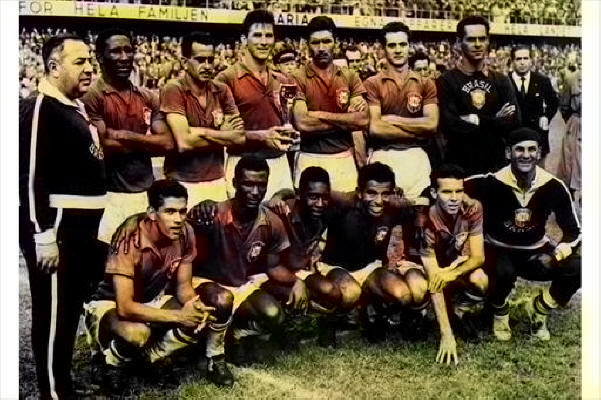

In [15]:
main()